In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.image as img


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("apollo2506/facial-recognition-dataset")
train_dir = os.path.join(path, 'Training/Training/')
test_dir = os.path.join(path, 'Testing/Testing/')

# Print the directories
print(train_dir)
print(test_dir)
print("Path to dataset files:", path)

100%|██████████| 59.7M/59.7M [00:02<00:00, 30.6MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/apollo2506/facial-recognition-dataset/versions/3/Training/Training/
/root/.cache/kagglehub/datasets/apollo2506/facial-recognition-dataset/versions/3/Testing/Testing/
Path to dataset files: /root/.cache/kagglehub/datasets/apollo2506/facial-recognition-dataset/versions/3


Data Preprocessing

1. Load and preprocess the images.
2. Resize the images to a uniform size (e.g., 48x48 or 64x64 pixels).
3. Normalize the pixel values.
4. Split the dataset into training, validation, and test sets.

In [ ]:
# Train data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip= True,
    fill_mode='nearest')

# test Data Augmentation
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip= True,
    fill_mode='nearest')

train_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (64, 64),
                                            batch_size = 4,
                                            class_mode = 'categorical')
no_of_validation_images = len(test_set)
validation_steps = np.ceil(no_of_validation_images)

Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [ ]:
class_dir=['Angry','Fear','Happy','Neutral','Sad','Suprise']

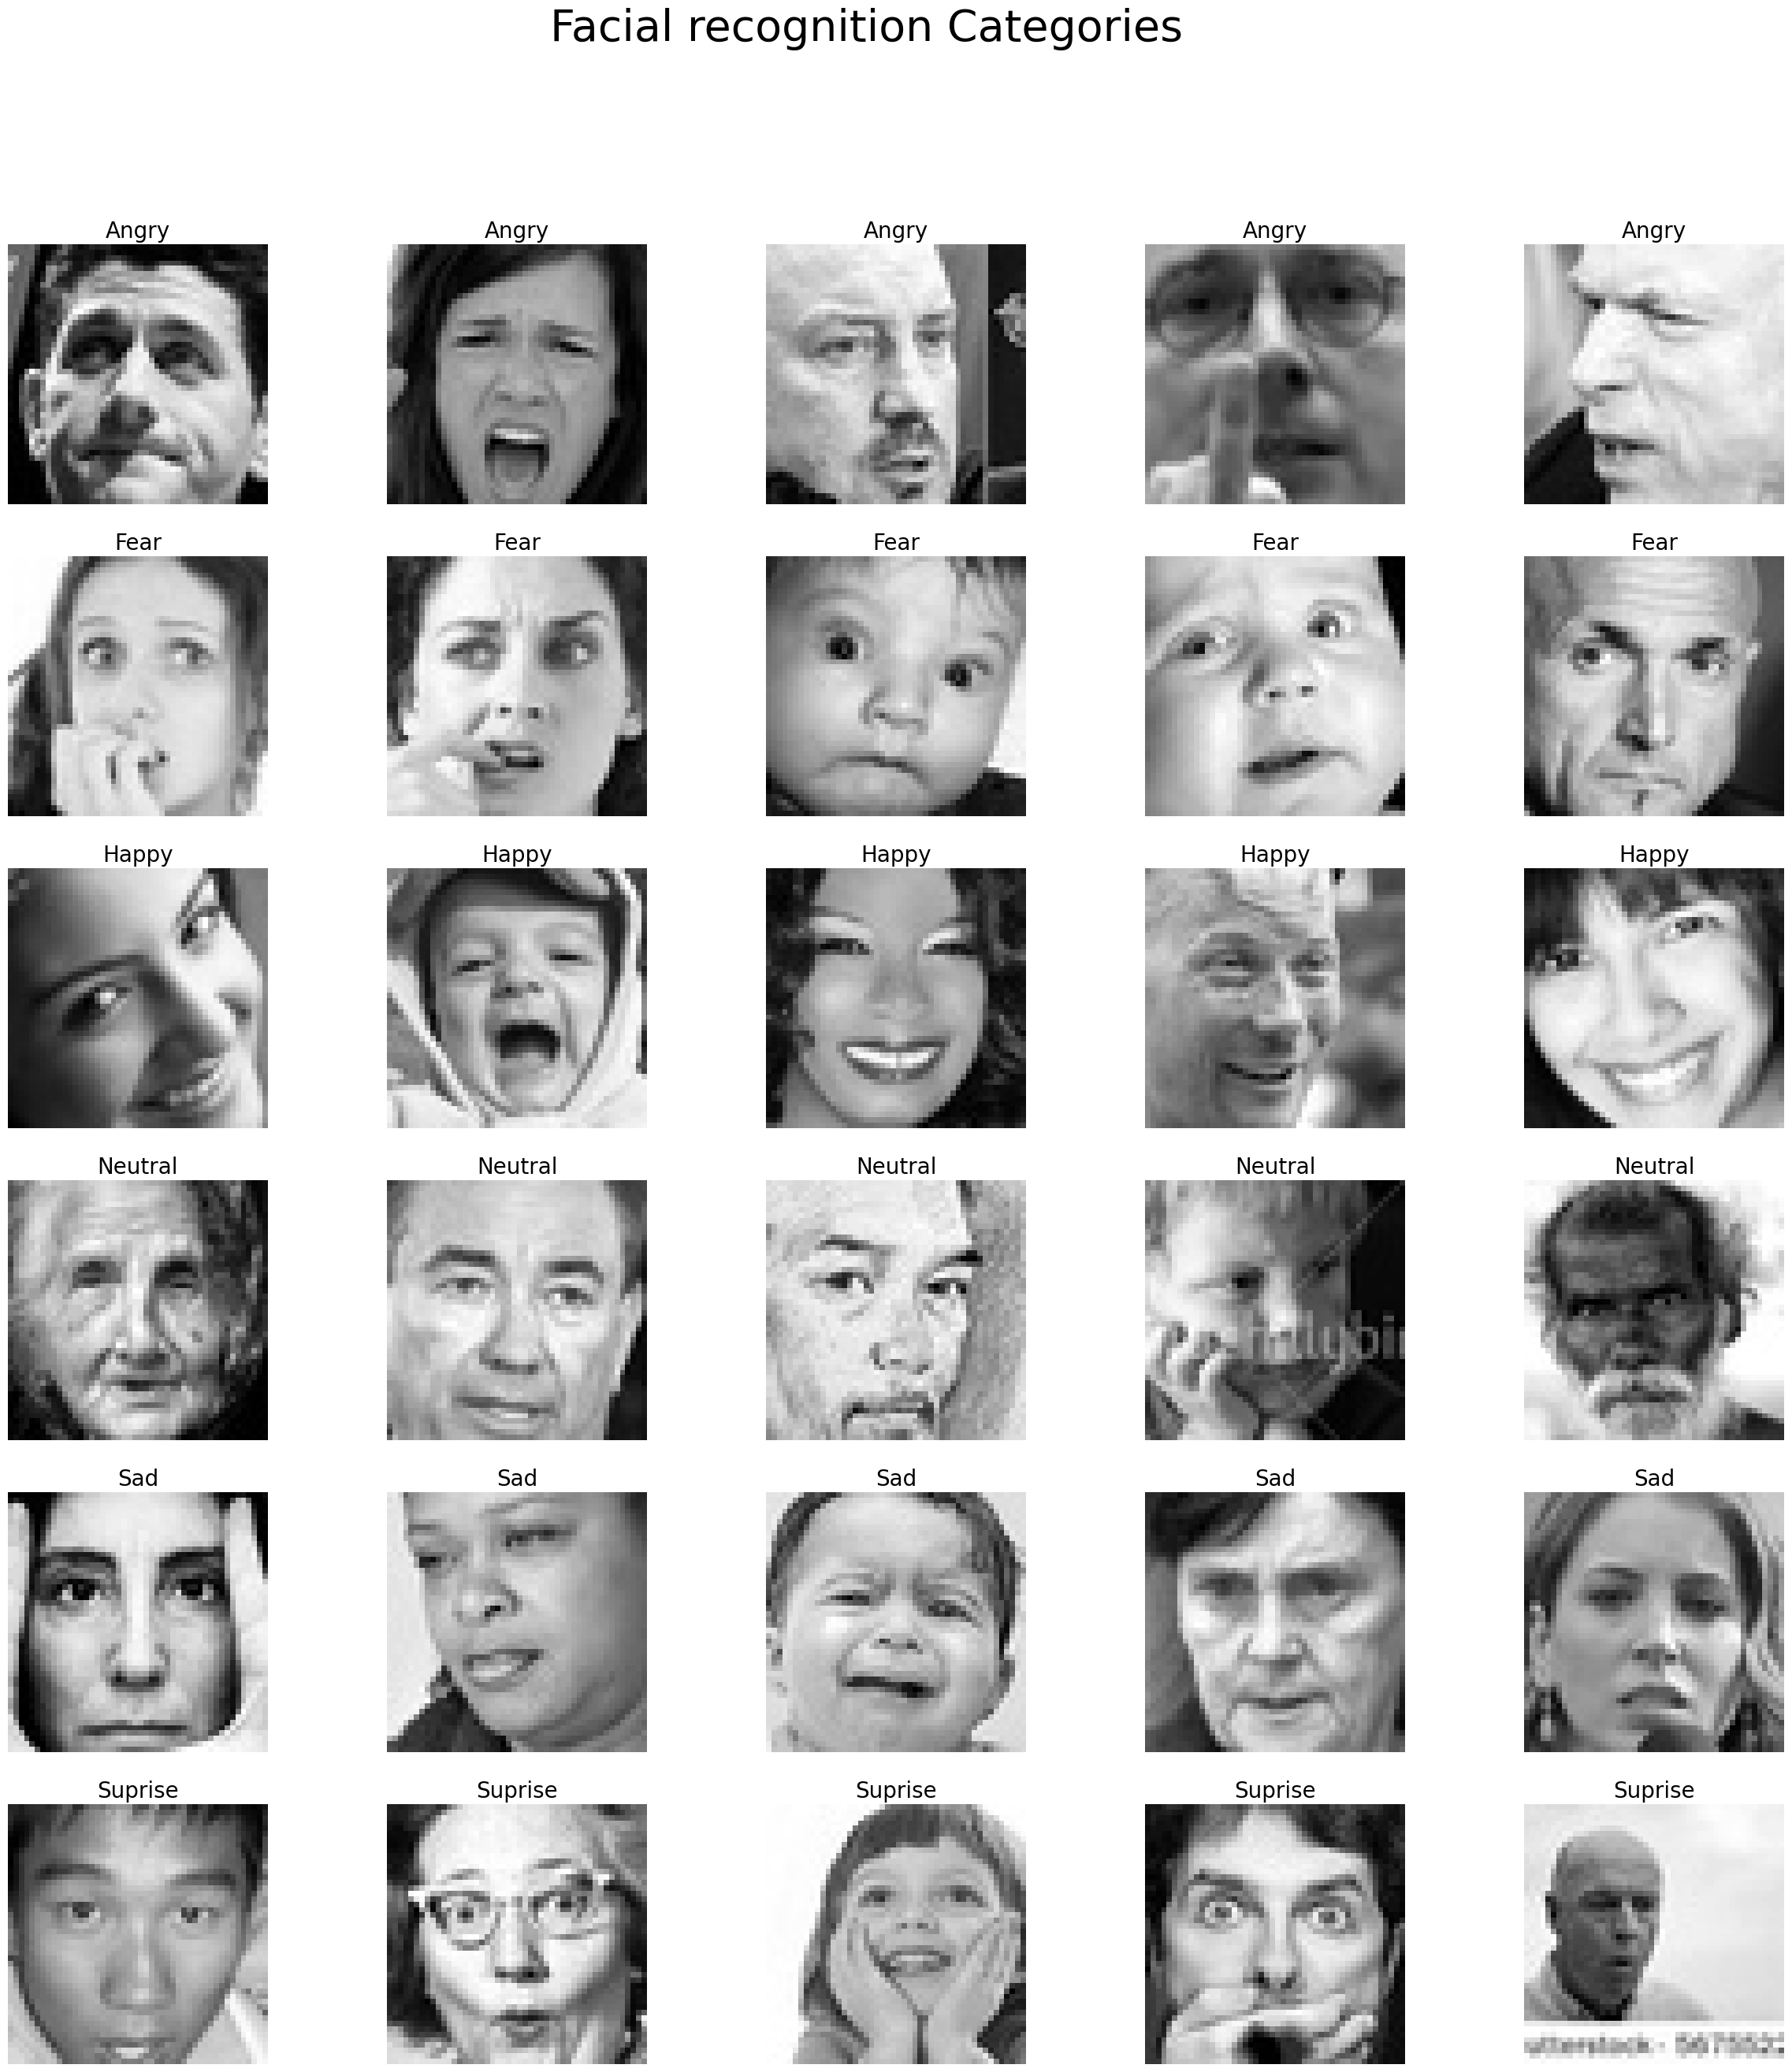

In [ ]:
fig, ax = plt.subplots(6,5, figsize=(30,30))
fig.suptitle('Facial recognition Categories',color='black',fontsize=40)
for i in range(6):
    for j in range(5):
        im_src = train_dir + class_dir[i] + '/'
        FileNames = os.listdir(im_src)
        np.random.shuffle(FileNames)
        im_src = str(im_src + FileNames[j])
        imag = img.imread(im_src)
        ax[i, j].imshow(imag,cmap='gray')
        ax[i, j].set_title(class_dir[i], fontsize=20)
        ax[i,j].axis('off')

Model Architecture

1. Import at least 2 pre-trained models (ResNet, VGG16, AlexNet) or any other
variations of them.
2. Add any needed layers for classification and apply transfer learning whenever
required.

# **Resnet**

In [ ]:
# Load the pre-trained ResNet50 model (without the top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers of ResNet50
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(512, activation='relu')(x)  # Fully connected layer
predictions = Dense(6, activation='softmax')(x)  # Output layer for 6 classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Show model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 70, 70, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 32, 32, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 32, 32, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 32, 32, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 34, 34, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 16, 16, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 16, 16, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 16, 16, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 16, 16, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 16, 16, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 16, 16, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 16, 16, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,639,878 (93.99 MB)

 Trainable params: 1,052,166 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_set,
    validation_data=test_set,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


884/884 ━━━━━━━━━━━━━━━━━━━━ 115s 110ms/step - accuracy: 0.2726 - loss: 2.1828 - val_accuracy: 0.3290 - val_loss: 1.6857
Epoch 2/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 87s 98ms/step - accuracy: 0.3404 - loss: 1.6552 - val_accuracy: 0.3549 - val_loss: 1.6119
Epoch 3/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 86s 97ms/step - accuracy: 0.3570 - loss: 1.5965 - val_accuracy: 0.3639 - val_loss: 1.5809
Epoch 4/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 88s 98ms/step - accuracy: 0.3652 - loss: 1.5684 - val_accuracy: 0.3649 - val_loss: 1.5674
Epoch 5/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 139s 96ms/step - accuracy: 0.3727 - loss: 1.5583 - val_accuracy: 0.3801 - val_loss: 1.5566
Epoch 6/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 142s 96ms/step - accuracy: 0.3816 - loss: 1.5434 - val_accuracy: 0.3720 - val_loss: 1.5573
Epoch 7/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 161s 117ms/step - accuracy: 0.3842 - loss: 1.5309 - val_accuracy: 0.3830 - val_loss: 1.5387
Epoch 8/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 123s 96ms/step - accuracy: 0.3930 - loss: 1.5269 - val_

In [ ]:
# Fine-tuning: Unfreeze some of the last layers of the base model
for layer in base_model.layers[-10:]:  # Unfreeze the last 10 layers
    layer.trainable = True

# Recompile the model after unfreezing
model.compile(optimizer=Adam(learning_rate=0.00001),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model with early stopping
history_fine = model.fit(
    train_set,
    validation_data=test_set,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 108s 107ms/step - accuracy: 0.4064 - loss: 1.4891 - val_accuracy: 0.4026 - val_loss: 1.5002
Epoch 2/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 148s 120ms/step - accuracy: 0.4137 - loss: 1.4845 - val_accuracy: 0.3989 - val_loss: 1.5044
Epoch 3/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 107s 120ms/step - accuracy: 0.4130 - loss: 1.4743 - val_accuracy: 0.4099 - val_loss: 1.4904
Epoch 4/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 86s 96ms/step - accuracy: 0.4144 - loss: 1.4680 - val_accuracy: 0.4149 - val_loss: 1.4896
Epoch 5/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 86s 97ms/step - accuracy: 0.4196 - loss: 1.4582 - val_accuracy: 0.4136 - val_loss: 1.4866
Epoch 6/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 85s 96ms/step - accuracy: 0.4200 - loss: 1.4566 - val_accuracy: 0.4106 - val_loss: 1.4877
Epoch 7/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 142s 97ms/step - accuracy: 0.4192 - loss: 1.4612 - val_accuracy: 0.4145 - val_loss: 1.4828
Epoch 8/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 86s 96ms/step - accuracy: 0.4274 - loss: 1.

In [ ]:
test_loss, test_acc = model.evaluate(test_set)
print(f"Test Accuracy: {test_acc:.4f}")

1767/1767 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.4123 - loss: 1.4700
Test Accuracy: 0.4149


# **VGG16**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers


In [ ]:
base_model2 = VGG16(input_shape=[64,64,3], weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
base_model2.trainable = False
inputs2 = tf.keras.Input(shape=(64, 64, 3))

In [ ]:
x2 = base_model2(inputs2, training=False)
x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)
outputs2 = tf.keras.layers.Dense(6, activation = 'sigmoid')(x2)
model2 = tf.keras.Model(inputs2, outputs2)
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 2, 2, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,717,766 (56.14 MB)

 Trainable params: 3,078 (12.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
adam2 = optimizers.Adam()
model2.compile(loss='categorical_crossentropy',
              optimizer=adam2,
              metrics=['accuracy'])

In [ ]:
history2 = model2.fit(
    train_set,
    validation_data=test_set,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 88s 96ms/step - accuracy: 0.2352 - loss: 6.2615 - val_accuracy: 0.3028 - val_loss: 2.2735
Epoch 2/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 158s 116ms/step - accuracy: 0.3052 - loss: 2.1029 - val_accuracy: 0.3024 - val_loss: 1.8700
Epoch 3/20
884/884 ━━━━━━━━━━━━━━━━━━━━ 83s 93ms/step - accuracy: 0.3115 - loss: 1.8643 - val_accuracy: 0.3034 - val_loss: 1.8329


In [ ]:
# Fine tuning of VGG16
# Fine-tuning: Unfreeze some of the last layers of the base model
for layer in base_model2.layers[-10:]:  # Unfreeze the last 10 layers
    layer.trainable = True

# Recompile the model after unfreezing
model2.compile(optimizer=Adam(learning_rate=0.00001),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model with early stopping
history_fine2 = model2.fit(
    train_set,
    validation_data=test_set,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 98s 104ms/step - accuracy: 0.3270 - loss: 1.6957 - val_accuracy: 0.3982 - val_loss: 1.5097
Epoch 2/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 88s 99ms/step - accuracy: 0.4136 - loss: 1.4750 - val_accuracy: 0.4353 - val_loss: 1.4345
Epoch 3/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 140s 96ms/step - accuracy: 0.4432 - loss: 1.4074 - val_accuracy: 0.4421 - val_loss: 1.4224
Epoch 4/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 87s 98ms/step - accuracy: 0.4787 - loss: 1.3398 - val_accuracy: 0.4743 - val_loss: 1.3499
Epoch 5/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 86s 97ms/step - accuracy: 0.4854 - loss: 1.3119 - val_accuracy: 0.4885 - val_loss: 1.2994
Epoch 6/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 145s 100ms/step - accuracy: 0.5042 - loss: 1.2647 - val_accuracy: 0.4936 - val_loss: 1.2943
Epoch 7/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 88s 99ms/step - accuracy: 0.5094 - loss: 1.2543 - val_accuracy: 0.5059 - val_loss: 1.2552
Epoch 8/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 85s 96ms/step - accuracy: 0.5226 - loss: 1.234

In [ ]:
test_loss, test_acc = model2.evaluate(test_set)
print(f"Test Accuracy: {test_acc:.4f}")

1767/1767 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.5321 - loss: 1.2028
Test Accuracy: 0.5229


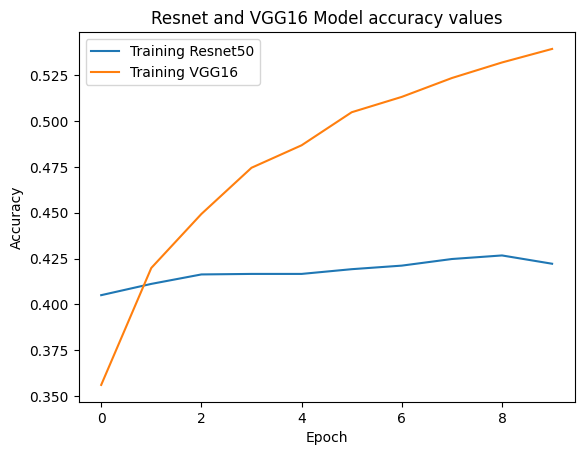

In [ ]:
# Plot training accurracy of both models
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine2.history['accuracy'])
plt.title('Resnet and VGG16 Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Resnet50', 'Training VGG16'], loc='upper left')
plt.show()

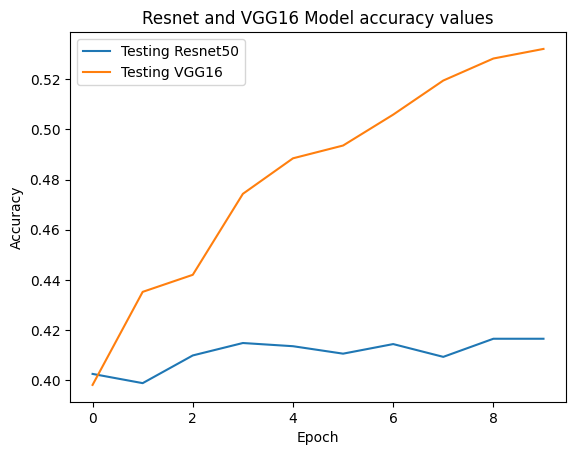

In [ ]:
# Plot tvalidation accurracy of both models
plt.plot(history_fine.history['val_accuracy'])
plt.plot(history_fine2.history['val_accuracy'])
plt.title('Resnet and VGG16 Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Testing Resnet50', 'Testing VGG16'], loc='upper left')
plt.show()